# Предсказание рейтинга ресторана на сайте TripAdvisor
<p>Работаем с датасетом, содержащим сведения о 40 000 ресторанах Европы.<br />

**Задача:** Обучить модель, которая будет предсказывать рейтинг ресторана по данным сайта TripAdvisor на основе имеющихся в датасете данных.</p>

### Загрузим необходимые библиотеки

In [1]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import plotly.figure_factory as ff
import plotly.graph_objs as go
import chart_studio.plotly as py
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statistics

### Внесем базовые переменные

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# Постоянный сегодняшний день
date_today = pd.to_datetime('2020-06-15')

### Создадим необходимые функции

In [3]:
# Обработка для Cuisine Style
def str_to_list(string):
    if pd.isnull(string):
        return []
    else:
        string = string.replace('"', '')
        string = string.replace('[', '')
        string = string.replace(']', '')
        string = string.replace("'", '')
        return string.split(', ')


# Обработка для Reviews
def reviews_to_list(string):
    if string == '[[], []]':
        return []
    else:
        string = string.replace(']]', '')
        string = string.replace("'", '')
        string = string.split('], [')[1]
        string = string.split(', ')
        return string


# Обработка для URL_TA
def url_ta_to_index(string):
    string = string.replace('/Restaurant_Review-g', '')
    string = string.split('-')
    return int(string[0])


# Построение графиков
def get_gr(col):
    df[col].value_counts(ascending=True).plot(kind='barh')


# Тестируем датасет Mean Absolute Error (MAE)
def mae_test(df_temp):
    y = df_temp['Rating']
    df_temp.drop(['Rating'], axis=1, inplace=True)
    X = df_temp

    # Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
    # Для тестирования мы будем использовать 20% от исходного датасета.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_SEED)

    # Создаём модель
    regr = RandomForestRegressor(
        n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

    # Обучаем модель на тестовом наборе данных
    regr.fit(X_train, y_train)

    # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
    # Предсказанные значения записываем в переменную y_pred
    y_pred = regr.predict(X_test)

    # Т. к. целевая переменная кратна 0.5, добавим здесь округление y_pred до 0.5
    y_pred = np.round(y_pred*2)/2

    # Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
    # Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
    print()
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print()

    # в RandomForestRegressor есть возможность вывести самые важные признаки для модели
    plt.rcParams['figure.figsize'] = (10, 10)
    feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
    feat_importances.nlargest(15).plot(kind='barh')

### Посмотрим на данные
**Дано в описании:**

- Restaurant_id — идентификационный номер ресторана / сети ресторанов;
- City — город, в котором находится ресторан;
- Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
- Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
- Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
- Price Range — диапазон цен в ресторане;
- Number of Reviews — количество отзывов о ресторане;
- Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
- URL_TA — URL страницы ресторана на TripAdvosor;
- ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [4]:
df = pd.read_csv('main_task.csv')
df

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963
...,...,...,...,...,...,...,...,...,...,...
39995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,4.5,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414
39996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,3.5,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036
39997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,4.5,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615
39998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,4.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 2.0+ MB


### Пропуски

**Нет пропусков:**
- Restaurant_id
- City
- Ranking
- Rating
- Reviews
- URL_TA
- ID_TA

**Числовой формат данных:**
- Ranking
- Rating
- Number of Reviews

**Данные в виде списка (условно):**
- Cuisine Style
- Reviews

**Распределение целевой переменной**
<p>Оценка по 5-ти бальной шкале. Оценки кратны 0.5.</p>

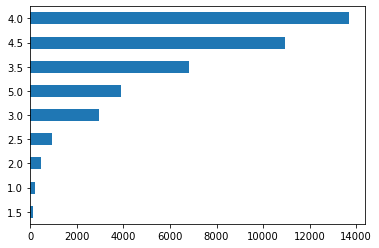

In [6]:
get_gr('Rating')

## Очистка данных
### Обработка NAN
Подсмотрено в демонстрационном ноутбуке на kaggle - создание столбцов с информацией о том, где были пропуски.

In [7]:
df['Cuisine_Style_isNAN'] = pd.isna(df['Cuisine Style']).astype('uint8')
df['Price_Range_isNAN'] = pd.isna(df['Price Range']).astype('uint8')
df['Number_of_Reviews_isNAN'] = pd.isna(
    df['Number of Reviews']).astype('uint8')

**Number of Reviews** - количество отзывов. Заполним пропуски нулями. Считаем, что, если строка не заполнена, пользователь только оценил ресторан не написав отзыв.

In [8]:
df['Number of Reviews'] = df['Number of Reviews'].fillna(0)

### Протестируем модель на исходных данных
Изначально у нас было три числовых столбца. Один из них является целевым. Определим МАЕ, как стартовый показатель и далее будем его улучшать. 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished

MAE: 0.409



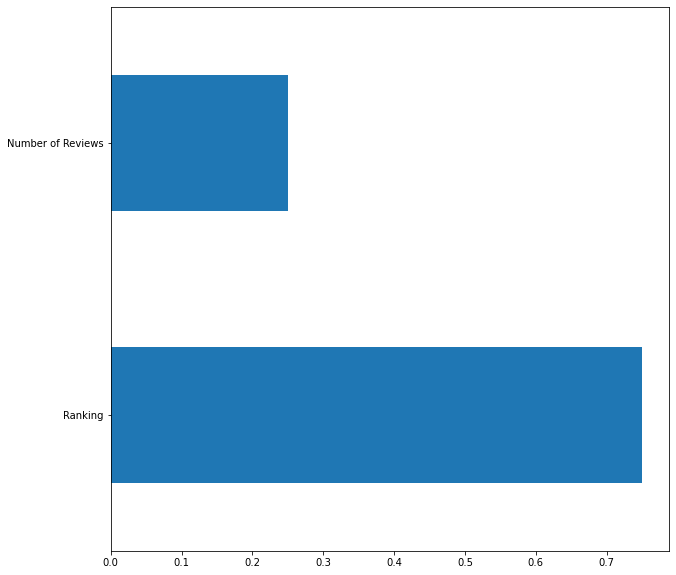

In [9]:
df_tmp = df[['Ranking', 'Number of Reviews', 'Rating']]

mae_test(df_tmp)

Стартуем с данного показателя MAE.

## Обработка признаков
**Restaurant_id** - очевидно, не несет никакой практической информации. Удалим его.

In [10]:
df.drop(['Restaurant_id'], axis=1, inplace=True)

### Города
**City** - пропусков нет. Посмотрим на данные.

In [11]:
print('Кол-во городов: ', df['City'].nunique())

Кол-во городов:  31


In [12]:
print('Ресторанов в городе:')
df['City'].value_counts()

Ресторанов в городе:


London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: City, dtype: int64

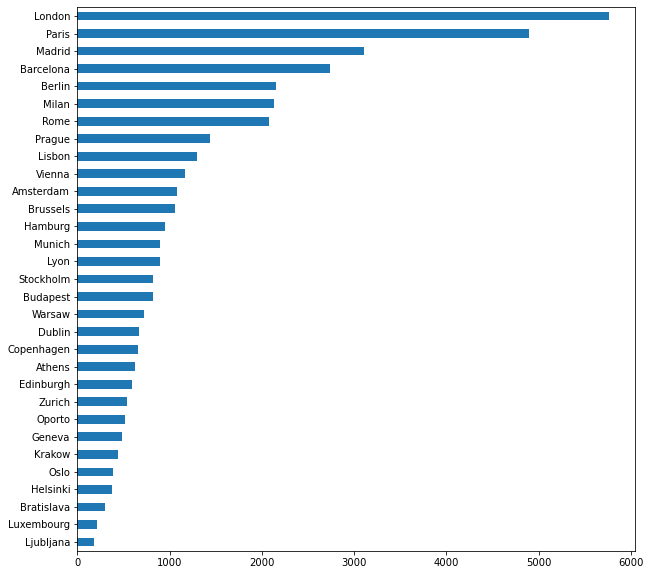

In [13]:
get_gr('City')

**Создадим признак Rest_counts** - кол-во ресторанов в городе.

In [14]:
df_tmp = df['City'].value_counts()
df['Rest_counts'] = df['City'].apply(lambda x: df_tmp[x])

**Добавим в датасет популяцию городов City_pop** - внешний источник данных: Википедия.<br />
К сожалению, в источнике популяцию городов представлена за разные годы, что будет вносить дополнительную погрешность в данные.

In [15]:
dict_tmp = {
    'London': 8787892,
    'Paris': 2140526,
    'Madrid': 3223334,
    'Barcelona': 1620343,
    'Berlin': 3601131,
    'Milan': 1366180,
    'Rome': 2872800,
    'Prague': 1280508,
    'Lisbon': 505526,
    'Vienna': 1840573,
    'Amsterdam': 859732,
    'Brussels': 144784,
    'Hamburg': 1830584,
    'Munich': 1456039,
    'Lyon': 515695,
    'Stockholm': 961609,
    'Budapest': 1749734,
    'Warsaw': 1758143,
    'Dublin': 553165,
    'Copenhagen': 615993,
    'Athens': 655780,
    'Edinburgh': 476100,
    'Zurich': 402275,
    'Oporto': 221800,
    'Geneva': 196150,
    'Krakow': 766739,
    'Oslo': 673469,
    'Helsinki': 643272,
    'Bratislava': 413192,
    'Luxembourg': 576249,
    'Ljubljana': 277554
}

df['City_pop'] = df['City'].apply(lambda x: dict_tmp[x])

**Добавим столбец Rest_density** - сколько ресторанов приходится на человека в городе (плотность ресторанов)

In [16]:
df['Rest_density'] = df['Rest_counts'] / df['City_pop']

### Поработаем со странами

**Добавим столбец Capital** - является ли город столицей.

In [17]:
dict_tmp = {
    'London': 1,
    'Paris': 1,
    'Madrid': 1,
    'Barcelona': 0,
    'Berlin': 1,
    'Milan': 0,
    'Rome': 1,
    'Prague': 1,
    'Lisbon': 1,
    'Vienna': 1,
    'Amsterdam': 1,
    'Brussels': 1,
    'Hamburg': 0,
    'Munich': 0,
    'Lyon': 0,
    'Stockholm': 1,
    'Budapest': 1,
    'Warsaw': 1,
    'Dublin': 1,
    'Copenhagen': 1,
    'Athens': 1,
    'Edinburgh': 1,
    'Zurich': 1,
    'Oporto': 0,
    'Geneva': 1,
    'Krakow': 0,
    'Oslo': 1,
    'Helsinki': 1,
    'Bratislava': 1,
    'Luxembourg': 1,
    'Ljubljana': 1
}

df['Capital'] = df['City'].apply(lambda x: dict_tmp[x])

**Добавим столбец Country** - название страны.

In [18]:
dict_tmp = {
    'London': 'UK',
    'Paris': 'FR',
    'Madrid': 'ESP',
    'Barcelona': 'ESP',
    'Berlin': 'GER',
    'Milan': 'IT',
    'Rome': 'IT',
    'Prague': 'Czech',
    'Lisbon': 'PORT',
    'Vienna': 'Austria',
    'Amsterdam': 'Nederlands',
    'Brussels': 'BELG',
    'Hamburg': 'GER',
    'Munich': 'GER',
    'Lyon': 'FR',
    'Stockholm': 'Sweden',
    'Budapest': 'Hungary',
    'Warsaw': 'PL',
    'Dublin': 'Ireland',
    'Copenhagen': 'Denmark',
    'Athens': 'Greece',
    'Edinburgh': 'Schotland',
    'Zurich': 'Switzerland',
    'Oporto': 'PORT',
    'Geneva': 'Switzerland',
    'Krakow': 'PL',
    'Oslo': 'Norway',
    'Helsinki': 'Finland',
    'Bratislava': 'Slovakia',
    'Luxembourg': 'Luxembourg',
    'Ljubljana': 'Slovenija'
}

df['Country'] = df['City'].apply(lambda x: dict_tmp[x])

**Посмотрим на страны**

In [19]:
print('Кол-во стран: ', df['Country'].nunique())

Кол-во стран:  23


In [20]:
print('Ресторанов в стране:')
df['Country'].value_counts()

Ресторанов в стране:


ESP            5842
FR             5789
UK             5757
IT             4211
GER            3997
PORT           1813
Czech          1443
PL             1170
Austria        1166
Nederlands     1086
BELG           1060
Switzerland    1019
Sweden          820
Hungary         816
Ireland         673
Denmark         659
Greece          628
Schotland       596
Norway          385
Finland         376
Slovakia        301
Luxembourg      210
Slovenija       183
Name: Country, dtype: int64

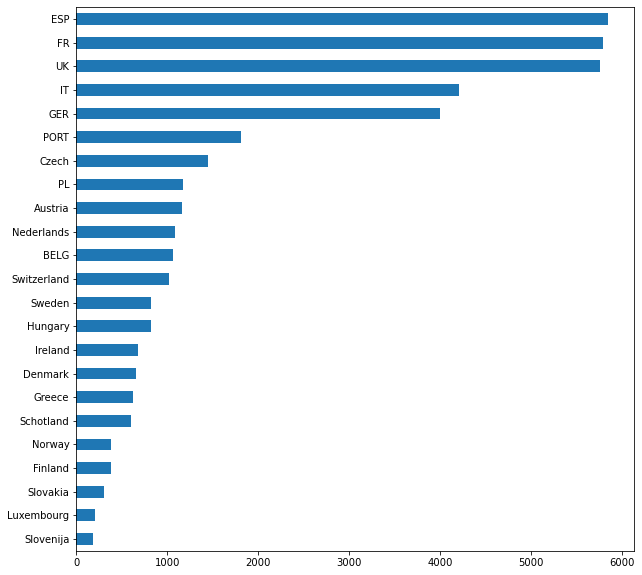

In [21]:
get_gr('Country')

**Создадим признак Rest_Count_Country** - количество ресторанов в стране.

In [22]:
df_tmp = df['Country'].value_counts()
df['Rest_Count_Country'] = df['Country'].apply(lambda x: df_tmp[x])

Видно, что по количеству ресторанов лидируют Лондон и Париж, но в группировке по странам лидирует Испания. Это значит, что существует разная сосредоточенность ресторанов (в Испании рестораны более рассосредоточены по стране, чем во Франции и Великобритании).

**Добавим столбец Rest_City_concentration** - коэффициент сосредоточенности ресторанов в городах страны.

In [23]:
df['Rest_City_concentration'] = df['Rest_counts'] / df['Rest_Count_Country']

**Добавим показатель Country_crime** - уровень преднамеренных убийств на душу населения в стране, как показатель преступности (возможно он будет влиять на рейтинг ресторана).

**Внешний источник:** Рейтинг стран мира по уровню преднамеренных убийств на душу населения. Рассчитывается по методике Управления Организации Объединённых Наций по наркотикам и преступности (УНП ООН).<br>
url: https://gtmarket.ru/ratings/homicide-rate/info

In [24]:
dict_tmp = {
    'ESP': 0.8,
    'FR': 1,
    'UK': 1,
    'IT': 0.9,
    'GER': 0.8,
    'PORT': 1.2,
    'Czech': 1,
    'PL': 1.2,
    'Austria': 0.9,
    'Nederlands': 0.9,
    'BELG': 1.6,
    'Switzerland': 0.6,
    'Sweden': 0.7,
    'Hungary': 1.9,
    'Ireland': 1.2,
    'Denmark': 0.8,
    'Greece': 1.7,
    'Schotland': 1,
    'Norway': 2.2,
    'Finland': 1.6,
    'Slovakia': 1.4,
    'Luxembourg': 0.8,
    'Slovenija': 0.7
}

df['Country_crime'] = df['Country'].apply(lambda x: dict_tmp[x])

**Добавим показатель Country_happy** - уровень счастья в стране. Возможно, он будет влиять на рейтинг ресторана.

**Внешний источник:** ИНСТИТУТ ЗЕМЛИ: РЕЙТИНГ СТРАН МИРА ПО УРОВНЮ СЧАСТЬЯ НАСЕЛЕНИЯ В 2017 ГОДУ.<br>
url: https://gtmarket.ru/news/2017/03/20/7316

In [25]:
dict_tmp = {
    'ESP': 6.403,
    'FR': 6.442,
    'UK': 6.714,
    'IT': 5.964,
    'GER': 6.951,
    'PORT': 5.195,
    'Czech': 6.609,
    'PL': 5.973,
    'Austria': 7.006,
    'Nederlands': 7.377,
    'BELG': 6.891,
    'Switzerland': 7.494,
    'Sweden': 7.284,
    'Hungary': 4.714,
    'Ireland': 6.977,
    'Denmark': 7.522,
    'Greece': 5.227,
    'Schotland': 6.714,
    'Norway': 7.537,
    'Finland': 7.469,
    'Slovakia': 6.098,
    'Luxembourg': 6.863,
    'Slovenija': 5.758
}

df['Country_happy'] = df['Country'].apply(lambda x: dict_tmp[x])

**Идея:**<br>
Возможно, стоит еще добавить численность населения стран и вывести показатель количества ресторанов на человека в стране, но т. к. в датасете нет статистики по небольшим городам, данные будут нерелевантны. Пока с географией закончим.

### Сделаем промежуточный замер МАЕ

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City                     40000 non-null  object 
 1   Cuisine Style            30717 non-null  object 
 2   Ranking                  40000 non-null  float64
 3   Rating                   40000 non-null  float64
 4   Price Range              26114 non-null  object 
 5   Number of Reviews        40000 non-null  float64
 6   Reviews                  40000 non-null  object 
 7   URL_TA                   40000 non-null  object 
 8   ID_TA                    40000 non-null  object 
 9   Cuisine_Style_isNAN      40000 non-null  uint8  
 10  Price_Range_isNAN        40000 non-null  uint8  
 11  Number_of_Reviews_isNAN  40000 non-null  uint8  
 12  Rest_counts              40000 non-null  int64  
 13  City_pop                 40000 non-null  int64  
 14  Rest_density          

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished

MAE: 0.1855



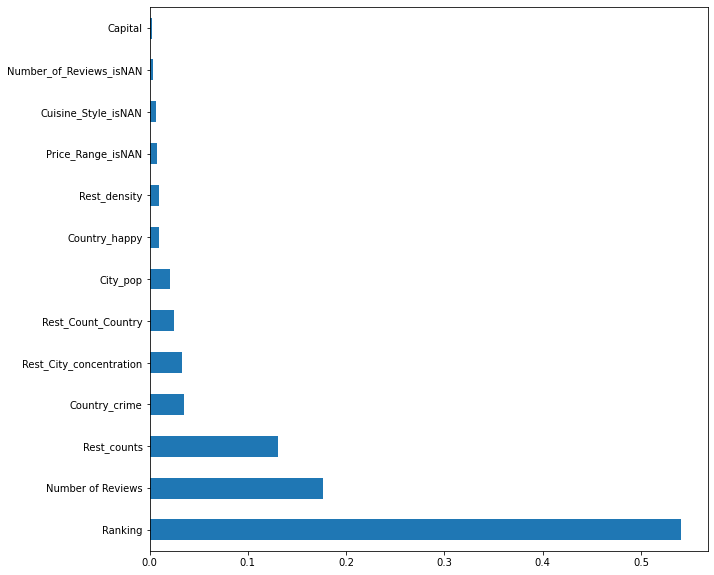

In [27]:
df_tmp = df[['Ranking', 'Rating', 'Number of Reviews', 'Cuisine_Style_isNAN', 'Price_Range_isNAN', 'Number_of_Reviews_isNAN',
             'Rest_counts', 'City_pop', 'Rest_density', 'Capital', 'Rest_Count_Country', 'Rest_City_concentration', 'Country_crime', 'Country_happy']]

mae_test(df_tmp)

Уже неплохо. Внешние источники сыграли свою роль.<br>
Лучший показатель из внешних источников, влияющий на результат - уровень преступности в стране **Country_crime**.<br>
Лучший из расчетных параметров - количество ресторанов в городе **Rest_counts**.

### Поработаем со стилями кухонь
Преобразуем стили кухонь в списки

In [28]:
df['Cuisine_Style_list'] = df['Cuisine Style'].apply(str_to_list)
df.drop(['Cuisine Style'], axis=1, inplace=True)

**Посмотрим какие кухни бывают**

In [29]:
cuisine_set = set()
for cuis_list in df['Cuisine_Style_list']:
    for cuis in cuis_list:
        cuisine_set.add(cuis)

print('Всего кухонь: ', len(cuisine_set))

Всего кухонь:  125


In [30]:
# Считаем сколько раз кухня встречается в ресторанах
cuisine_count = dict.fromkeys(cuisine_set, 0)
for cuis in cuisine_set:
    for cuis_list in df['Cuisine_Style_list']:
        if cuis in cuis_list:
            cuisine_count[cuis] += 1

cuisine_count = pd.Series(cuisine_count)
cuisine_count.sort_values(ascending=False)

Vegetarian Friendly    11189
European               10060
Mediterranean           6277
Italian                 5964
Vegan Options           4486
                       ...  
Burmese                    1
Xinjiang                   1
Latvian                    1
Salvadoran                 1
Yunnan                     1
Length: 125, dtype: int64

**Создадим параметр Cuisine_count** - количество кухонь в ресторане.<br>
Если пропуск - считаем, что кухня одна.

In [31]:
df['Cuisine_count'] = df['Cuisine_Style_list'].apply(
    lambda x: 1 if len(x) == 0 else len(x))

**Предположение:**

**Создадим параметр Cuisine_popular** - суммарная популярность кухонь. Популярность кухни = количеству ресторанов, в которых она представлена. Суммируем популярность всех кухонь, которые есть в ресторане.

**Создадим параметр Cuisine_popular_index** - индекс популярности кухни. Популярность кухни = количеству ресторанов, в которых она представлена. Суммируем популярность всех кухонь, которые есть в ресторане и делим на кол-во кухонь, которые есть в ресторане.
### *!!! Промежуточный тест показал ухудшение MAE после введения данных параметров, либо любого из них. Код деактивируем !!!*

In [32]:
# df['Cuisine_popular'] = 0
# df['Cuisine_popular_index'] = 0

# for i in range(0, len(df)):
#     string = df.loc[i]
#     if len(string['Cuisine_Style_list']) == 0:
#         continue
#     pop = 0
#     for cuis in string['Cuisine_Style_list']:
#         pop += cuisine_count[cuis]
#     df.at[i, 'Cuisine_popular'] = pop
#     df.at[i, 'Cuisine_popular_index'] = pop / string['Cuisine_count']

### Ranking — место, которое занимает ресторан среди всех ресторанов города
Посмотрим на данные.

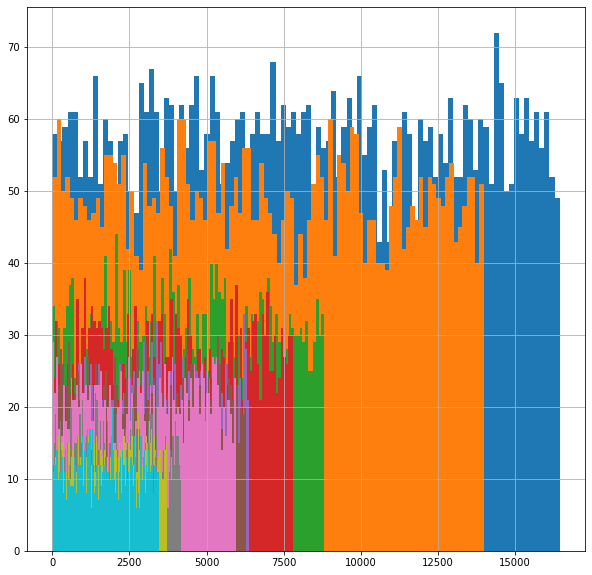

In [33]:
for x in (df['City'].value_counts())[0:10].index:
    df['Ranking'][df['City'] == x].hist(bins=100)
plt.show()

Очевидно, что если ресторан занимает 5е место из 1000, то он очень хороший, а если 5е место из 10, то он средний.

**Введем параметр Relative_rank** - относительного ранга = ранг / кол-во ресторанов в городе.

In [34]:
df['Relative_rank'] = df['Ranking'] / df['Rest_counts']

### Price Range — диапазон цен в ресторане
Посмотрим на данный параметр.

In [35]:
df['Price Range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: Price Range, dtype: int64

В столбце три варианта значений.<br>
В столбце есть пропуски. Самое популярное значение - средний диапазон цен.<br>
Заполним пропуски самым популярным значением.

In [36]:
df['Price Range'] = df['Price Range'].apply(
    lambda x: '$$ - $$$' if pd.isnull(x) else x)

Преобразуем диапазон цен в числовой формат (1 - низкий уровень цен, 2 - средний, 3 - высокий)

In [37]:
df['Price Range'] = df['Price Range'].apply(
    lambda x: 1 if x == '$' else 2 if x == '$$ - $$$' else 3)

### Number of Reviews — количество отзывов о ресторане
Показатель хорош сам по себе, поэтому его оставим в датасете без изменений.

**Предположение:**<br>
Возможно, чем больше город, тем больше отзывов.<br>
Также интересно посмотреть распределение количества отзывов по городам.

In [38]:
df_tmp = df.groupby(['City'])[
    'Number of Reviews'].sum().sort_values(ascending=False)

df_tmp

City
London        746139.0
Rome          583983.0
Paris         561444.0
Milan         352637.0
Barcelona     337566.0
Madrid        291655.0
Prague        159005.0
Lisbon        153705.0
Amsterdam     151909.0
Edinburgh     134393.0
Berlin        129786.0
Budapest      119171.0
Dublin         99463.0
Vienna         89407.0
Brussels       88021.0
Lyon           73148.0
Munich         67301.0
Oporto         64979.0
Stockholm      59075.0
Athens         58039.0
Copenhagen     56498.0
Krakow         50035.0
Warsaw         42169.0
Hamburg        40576.0
Zurich         39167.0
Oslo           34745.0
Geneva         27793.0
Helsinki       21252.0
Luxembourg     16184.0
Bratislava     13697.0
Ljubljana      12646.0
Name: Number of Reviews, dtype: float64

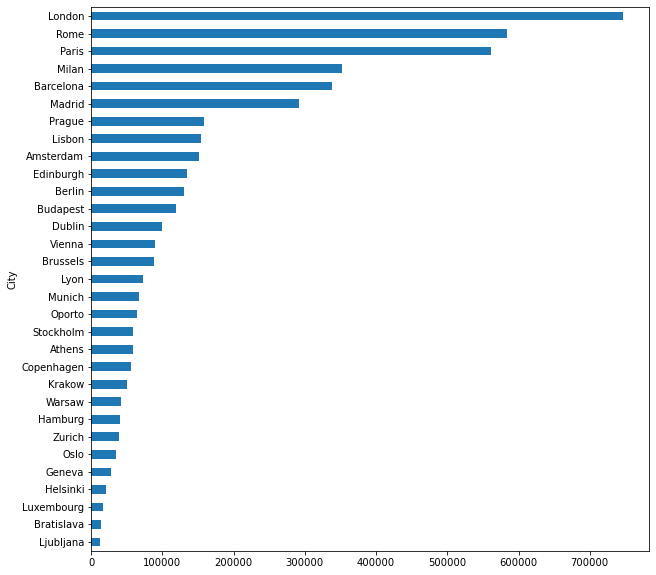

In [39]:
df_tmp.sort_values().plot(kind='barh')

**Добавим показатель Rev_in_city** - количество отзывов о ресторанах в городе.

In [40]:
df['Rev_in_city'] = df['City'].apply(lambda x: df_tmp[x])

**Добавим параметр Relative_rank_rev** - ранг ресторана относительно количества отзывов о ресторанах в городе.

In [41]:
df['Relative_rank_rev'] = df['Ranking'] / df['Rev_in_city']

### Reviews — данные о двух отзывах, которые отображаются на сайте ресторана
Пока столбец содержит текстовые данные, поищем ключевые слова в отзывах, которые могут повлиять на рейтинг и выведем наличие каждого ключевого слова в отдельный столбец:
- Terrible
- Horrible
- Not good
- Disappointing
- Worst
- Better
- Bad


- Excellent
- Best
- Amazing
- Great

In [42]:
# Заполним пропуски, если есть
df['Reviews'] = df['Reviews'].apply(
    lambda x: '[[], []]' if pd.isnull(x) else x)

In [43]:
df['Rev_Terrible'] = df['Reviews'].apply(
    lambda x: 1 if 'terrible' in x.lower() else 0)
df['Rev_Horrible'] = df['Reviews'].apply(
    lambda x: 1 if 'horrible' in x.lower() else 0)
df['Rev_Not_good'] = df['Reviews'].apply(
    lambda x: 1 if 'not good' in x.lower() else 0)
df['Rev_Disappointing'] = df['Reviews'].apply(
    lambda x: 1 if 'disappointing' in x.lower() else 0)
df['Rev_Worst'] = df['Reviews'].apply(
    lambda x: 1 if 'worst' in x.lower() else 0)
df['Rev_Better'] = df['Reviews'].apply(
    lambda x: 1 if 'better' in x.lower() else 0)
df['Rev_Bad'] = df['Reviews'].apply(
    lambda x: 1 if 'bad' in x.lower() else 0)
df['Rev_Excellent'] = df['Reviews'].apply(
    lambda x: 1 if 'excellent' in x.lower() else 0)
df['Rev_Best'] = df['Reviews'].apply(
    lambda x: 1 if 'best' in x.lower() else 0)
df['Rev_Amazing'] = df['Reviews'].apply(
    lambda x: 1 if 'amazing' in x.lower() else 0)
df['Rev_Great'] = df['Reviews'].apply(
    lambda x: 1 if 'great' in x.lower() else 0)

### Даты отзывов
Продолжим работать с отзывами.

**Создадим столбцы Reviews_date_first и Reviews_date_last** с первой и последней датой отзывов, соответственно.

In [44]:
df['Reviews_date_temp'] = df['Reviews'].apply(reviews_to_list)
df['Reviews_date_first'] = df['Reviews_date_temp'].apply(
    lambda x: x[1] if len(x) == 2 else None)
df['Reviews_date_last'] = df['Reviews_date_temp'].apply(
    lambda x: x[0] if len(x) > 0 else None)

# Преобразуем в формат дат
df['Reviews_date_first'] = pd.to_datetime(df['Reviews_date_first'])
df['Reviews_date_last'] = pd.to_datetime(df['Reviews_date_last'])

Посмотрим на минимальную дату отзывов в столбце последних дат, чтобы заполнить ей пропуски (если брать, например, среднее значение, то при расчете количества дней между отзывами могут появиться отрицательные значения).

In [45]:
df['Reviews_date_last'].min()

Timestamp('2004-04-21 00:00:00')

Заполним пропуски минимальной датой

In [46]:
df['Reviews_date_first'] = df['Reviews_date_first'].apply(
    lambda x: '2004-04-21' if pd.isnull(x) else x)
df['Reviews_date_last'] = df['Reviews_date_last'].apply(
    lambda x: '2004-04-21' if pd.isnull(x) else x)

**Создадим параметр date_delta** - сколько дней прошло между отзывами.

In [47]:
df['date_delta'] = (df['Reviews_date_last'] - df['Reviews_date_first']).dt.days

**Создадим параметр date_delta_today** - сколько дней прошло с даты последнего отзыва до условной сегодняшней даты.<br>
Возможно более свежие отзывы по-другому влияют на рейтинг, чем более ранние.

In [48]:
df['date_delta_today'] = (date_today - df['Reviews_date_last']).dt.days

**Создадим параметр Rev_year** - год последнего отзыва.<br>
Возможно, с годами уровень лояльности пользователей меняется.

In [49]:
df['Rev_year'] = df['Reviews_date_last'].dt.year

**Создадим параметр Rev_weekday** - день недели последнего отзыва.<br>
Возможно, от дня недели зависит настроение пользователя, что сказывается на оценке ресторана.

In [50]:
df['Rev_weekday'] = df['Reviews_date_last'].dt.dayofweek

**Еще идеи:**<br>
Все внесенные параметры последовательно улучшали результат тестирования.<br>
Кроме того, пробовал вводить столбцы - месяц последнего отзыва и сезон последнего отзыва - данные параметры ухудшали промежуточный результат, поэтому из итогового ноутбука они удалены.

Удалим лишние столбцы, на основе которых работали с датами.

In [51]:
df.drop(['Reviews', 'Reviews_date_temp', 'Reviews_date_first',
         'Reviews_date_last'], axis=1, inplace=True)

### URL_TA — URL страницы ресторана на TripAdvosor
В url страницы кроме идентификатора ресторана, закодирован идентификатор города с префиксом 'g'

**Добавим данный параметр url_ta_index** - индекс города в url.

In [52]:
df['url_ta_index'] = df['URL_TA'].apply(url_ta_to_index)
df.drop(['URL_TA'], axis=1, inplace=True)

### ID_TA — идентификатор ресторана в базе данных TripAdvisor
Данный параметр представляет собой числовой идентификатор с префиксом 'd'.<br>
Предположим, что индентификатор присваивается последовательно в момент регистрации ресторана на сайте TripAdvisor, а значит косвенно по нему можно судить о возрасте ресторана, что может влиять на рейтинг.

Уберем префикс 'd' чтобы остались только числовые значения.

In [53]:
df['ID_TA'] = df['ID_TA'].apply(lambda x: int(x[1:]))

## Промежуточные итоги
Посмотрим корреляции полученных признаков.

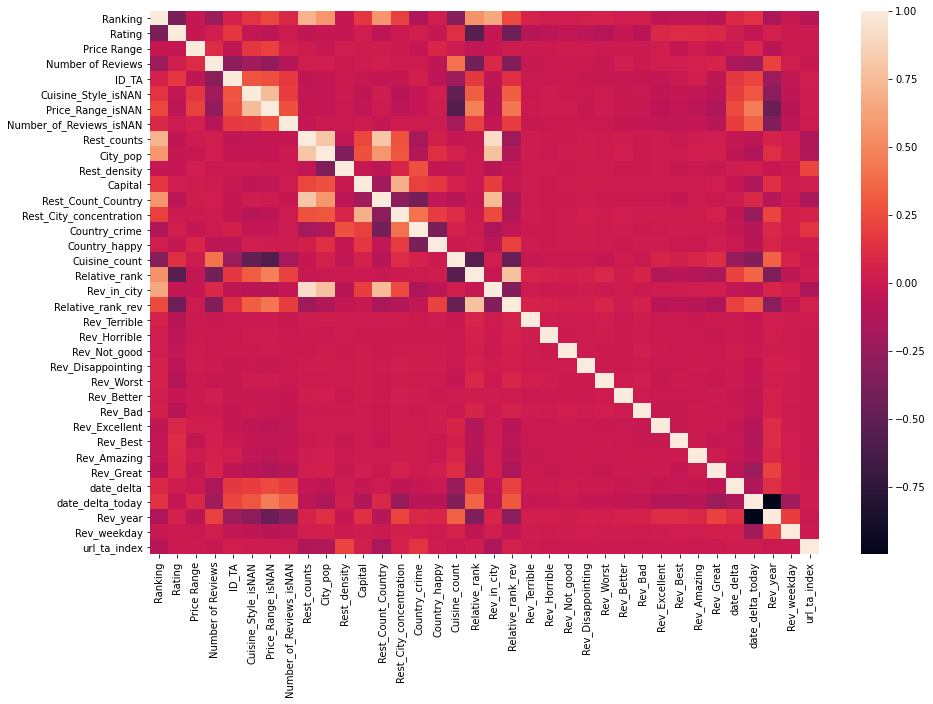

In [54]:
plt.rcParams['figure.figsize'] = (15, 10)
sns.heatmap(df.corr())

Есть довольно сильно скоррелированные параметры, однако удалять их не будем для более точной работы модели.

**Параметры дата фрейма на текущий момент:**

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City                     40000 non-null  object 
 1   Ranking                  40000 non-null  float64
 2   Rating                   40000 non-null  float64
 3   Price Range              40000 non-null  int64  
 4   Number of Reviews        40000 non-null  float64
 5   ID_TA                    40000 non-null  int64  
 6   Cuisine_Style_isNAN      40000 non-null  uint8  
 7   Price_Range_isNAN        40000 non-null  uint8  
 8   Number_of_Reviews_isNAN  40000 non-null  uint8  
 9   Rest_counts              40000 non-null  int64  
 10  City_pop                 40000 non-null  int64  
 11  Rest_density             40000 non-null  float64
 12  Capital                  40000 non-null  int64  
 13  Country                  40000 non-null  object 
 14  Rest_Count_Country    

**Промежуточный тест МАЕ:**

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished

MAE: 0.1635625



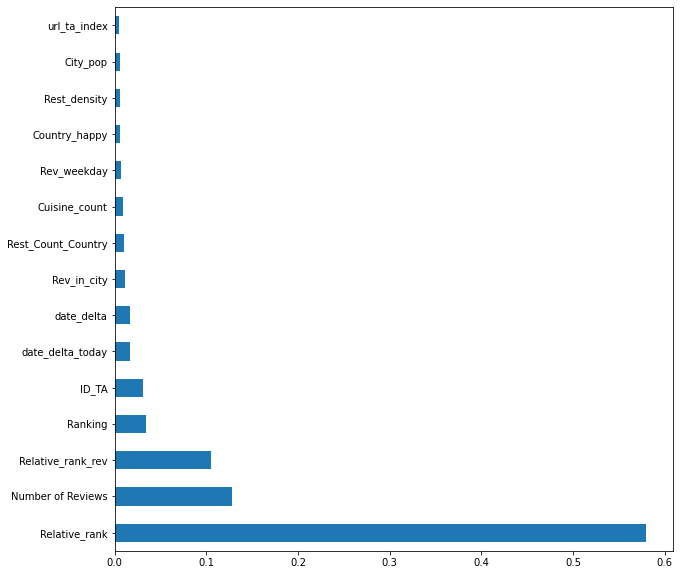

In [56]:
df_tmp = df[[
    'Ranking', 'Rating', 'Price Range', 'Number of Reviews', 'Cuisine_Style_isNAN', 'Price_Range_isNAN', 'Number_of_Reviews_isNAN', 'Rest_counts', 'City_pop', 'Rest_density', 'Capital', 'Rest_Count_Country', 'Rest_City_concentration', 'Country_crime', 'Country_happy', 'Cuisine_count', 'Relative_rank', 'Rev_in_city', 'Relative_rank_rev', 'Rev_Terrible', 'Rev_Horrible', 'Rev_Not_good', 'Rev_Disappointing', 'Rev_Worst', 'Rev_Better', 'Rev_Bad', 'Rev_Excellent', 'Rev_Best', 'Rev_Amazing', 'Rev_Great', 'date_delta', 'date_delta_today', 'Rev_year', 'Rev_weekday', 'ID_TA', 'url_ta_index'
]]

mae_test(df_tmp)

Удалось еще улучшить качество предсказания рейтинга. На текущий момент основным параметром, влияющим на результат, является созданный параметр Relative_rank.

## Текстовые и категориальные признаки
Переформатируем информацию о странах и городах в dummy-переменные.

In [57]:
df = pd.get_dummies(df, columns=['City', 'Country'])

Переформатируем информацию о кухнях в dummy-переменные.

In [58]:
for cuis in cuisine_set:
    df[cuis] = 0
    df[cuis] = df['Cuisine_Style_list'].apply(lambda x: 1 if cuis in x else 0)

df.drop(['Cuisine_Style_list'], axis=1, inplace=True)

## Финальный тест модели

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished

MAE: 0.1599375



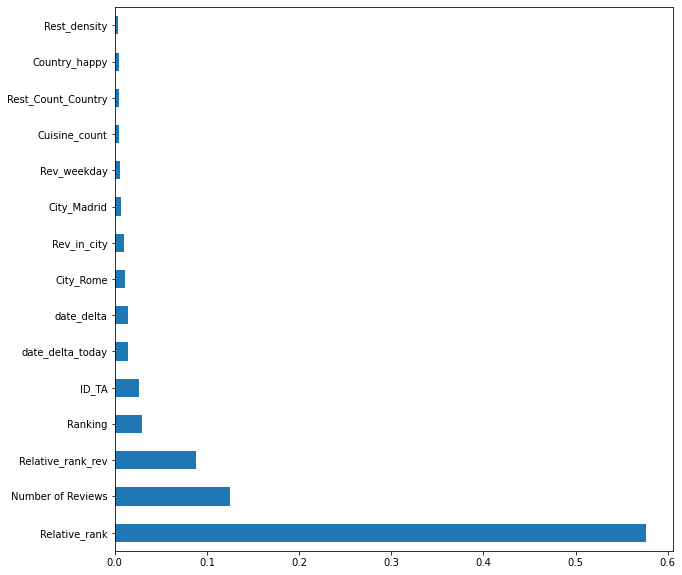

In [59]:
mae_test(df)

## Вывод
Удалось очистить и обогатить данными первоначальный датасет, благодаря чему существенно возросла точность предсказания рейтинга моделью (МАЕ было: 0.42548655925324674, стало: 0.194719375).

Данные можно еще улучшить, через парсинг дополнительных параметров ресторанов и применения других внешних источников.

Кроме того, видел в примерах работ округление предсказанных рейтингов до степени округления целевой переменной. На мой взгляд, это не улучшает модель предсказания рейтинга, а подгоняет результат предсказания под результат. Округленное предсказание более точно попадает в значения целевых переменных улучшая показатель МАЕ.

После того, как модель формирует y_pred, внедрил код округления значений y_pred до 0.5: **y_pred = np.round(y_pred*2)/2**, что дало существенное улучшение показателя МАЕ.